# This is a Logistic Regression Model to predict if a product/food/movie review is either positive or negative.

Dataset: https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences

### Importing Libraries

In [1]:

# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pandas as pd
import random
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import os
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Importing the labelled dataset

In [ ]:
from google.colab import files


uploaded = files.upload()

os.listdir()

Saving yelp_labelled.txt to yelp_labelled.txt


['.config',
 'yelp_labelled.txt',
 'imdb_labelled.txt',
 'amazon_cells_labelled.txt',
 'sample_data']

## Pre-processing the data

Concatenating the archives into one dataframe, and adding reviews with negations, for the model to learn how to handle this kind of text.

In [ ]:
#data = pd.read_csv('imdb_labelled.txt', sep='\t', header=None, names=['review', 'label'])

def carregar_reviews(file_path):
    # Lê o arquivo .txt separando por tabulação (\t)
    datas = pd.read_csv(file_path, sep='\t', header=None, names=['review', 'label'])
    return datas

imdb_data = carregar_reviews("imdb_labelled.txt")
amazon_data = carregar_reviews("amazon_cells_labelled.txt")
yelp_data = carregar_reviews("yelp_labelled.txt")

# Combinando em um único DataFrame
data = pd.concat([imdb_data, amazon_data, yelp_data], ignore_index=True)

# Adicionando reviews com negações para o dataset
tricky_reviews = [
    ("not bad", 1),
    ("not great", 0),
    ("This movie is not good at all.", 0),
    ("The food wasn't fresh and tasted awful.", 0),
    ("I can't recommend this product, it broke immediately.", 0),
    ("Not what I expected, very disappointed.", 0),
    ("The service was hardly acceptable.", 0),
    ("The book isn't worth your time.", 0),
    ("Nothing special about this place.", 0),
    ("The hotel is not clean and smells bad.", 0),

    ("This isn't good, it's amazing!", 1),
    ("I don't dislike it at all.", 1),
    ("The app isn't without flaws, but it's useful.", 1),
    ("Not your typical boring movie.", 1),
    ("Couldn't be happier with the service!", 1),
    ("No complaints here, everything was perfect.", 1),
    ("It's not overrated, truly a masterpiece.", 1),
    ("Never tasted something so delicious.", 1)
]

data = pd.concat([data, pd.DataFrame(tricky_reviews, columns=['review', 'label'])], ignore_index=True)


data = data.sample(frac=1, random_state=42).reset_index(drop=True)

data.head(10)


,review,label
0,Don't bother - go to the store.,0
1,Made very sturdy.,1
2,Gave up trying to eat any of the crust (teeth ...,0
3,"I started this review with two stars, but I'm ...",0
4,If you like a loud buzzing to override all you...,0
5,This movie does an excellent job of revealing ...,1
6,The visual effects were AWFUL.,0
7,The best phone in market :).,1
8,The fries were great too.,1
9,I really hope the team behind this movie makes...,1


### Cleaning undesired characters, and making a WordCloud of both positive and negative reviews.

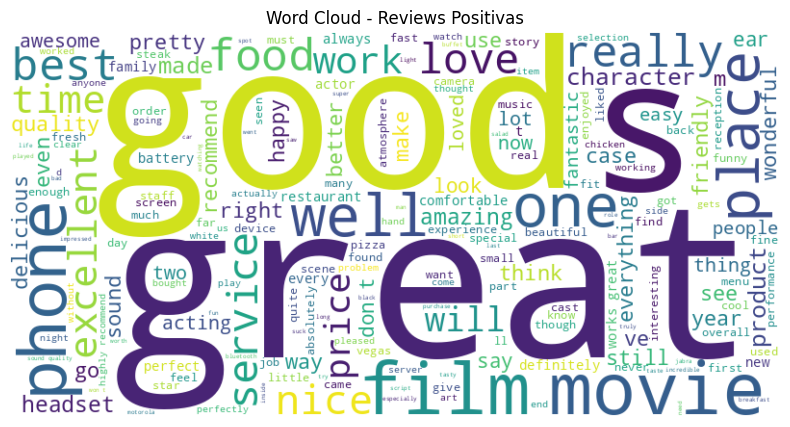

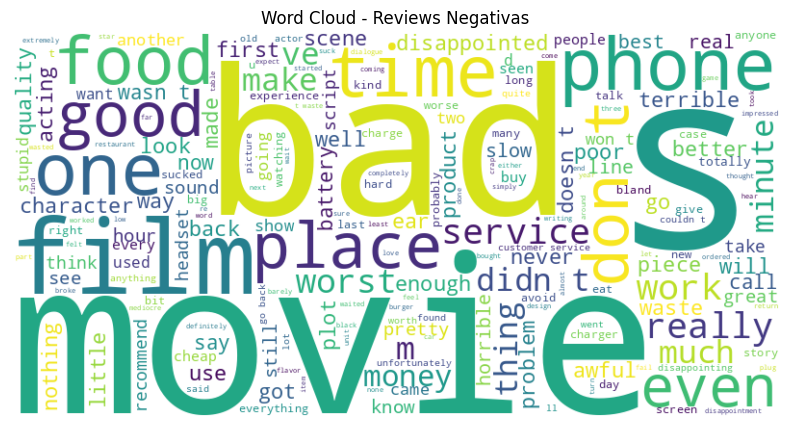

In [ ]:
# Função de limpeza
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)    # Remove menções
    text = re.sub(r"#\w+", "", text)    # Remove hashtags
    text = re.sub(r"[^a-zA-Záéíóúçãõ ]", " ", text)  # Remove caracteres especiais
    text = text.lower()  # Converte para minúsculas
    return text

data['cleaned_review'] = data['review'].apply(clean_text) # Reviews Limpas

#Criando o WordCloud
positive_reviews = data[data['label'] == 1]['cleaned_review']
negative_reviews = data[data['label'] == 0]['cleaned_review']

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Reviews Positivas')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Reviews Negativas')
plt.axis('off')
plt.show()

In the WordCloud, it's possible to see a lot of words that don't describe any kind of feeling, like movie, film, product, thing...

### Applying a function that removes the stopwords from the text, along with words that are not important to the classifier, based on the WordCloud.

In [ ]:
# Stopwords
stop_words = set(stopwords.words('english')).union({'movie', 'film', 'cinema', 'watch'})

# Remover "não" da lista de stopwords
negative_words = {
    'not', 'no', 'nor', 'neither', 'never', 'none', 'nobody', 'nothing', 'nowhere',
    'hardly', 'scarcely', 'barely', "don't", "doesn't", "didn't", "isn't", "aren't",
    "wasn't", "weren't", "won't", "wouldn't", "shan't", "shouldn't", "can't",
    "cannot", "couldn't"
}

# Remover as palavras negativas da lista de stopwords
stop_words = stop_words - negative_words

def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    return " ".join([word for word in words if word not in stop_words])

data['no_stopwords'] = data['cleaned_review'].apply(remove_stopwords)




### Tinkering with stemmers and lemmatizers, but i'm gonna use the lemmatized reviews for the training and testing.

In [ ]:
nlp = spacy.load('en_core_web_sm') # Spacy em inglês

#Stemming
def stemming(text):
    stemmer = RSLPStemmer()
    words = nltk.word_tokenize(text, language='english')
    return " ".join([stemmer.stem(word) for word in words])

#Lemmatization
def lemmatization(text):
  doc = nlp(text)
  return " ".join([token.lemma_ for token in doc])


data['stemmed_review'] = data['no_stopwords'].apply(stemming)
data['lemmatized_review'] = data['no_stopwords'].apply(lemmatization)

data[['no_stopwords', 'stemmed_review', 'lemmatized_review', 'label']].head(10)

,no_stopwords,stemmed_review,lemmatized_review,label
0,bother go store,both go stor,bother go store,0
1,made sturdy,mad sturdy,make sturdy,1
2,gave trying eat crust teeth still sore,gav trying eat crust teeth still sor,give try eat crust tooth still sore,0
3,started review two stars editing give one,started review two st editing giv one,start review two star edit give one,0
4,like loud buzzing override conversations phone,lik loud buzzing overrid conversatiom phon,like loud buzz override conversation phone,0
5,excellent job revealing complexity task incred...,excellent job revealing complexity task incred...,excellent job reveal complexity task incredibl...,1
6,visual effects awful,visual effect awful,visual effect awful,0
7,best phone market,best phon market,good phone market,1
8,fries great,fri great,fry great,1
9,really hope team behind makes movies continue ...,really hop te behind mak movi continu kind wei...,really hope team behind make movie continue ki...,1


## Creating tools for the model to handle negations on tricky reviews

In [ ]:
#Função para lidar com negações
def handle_negation(text):

    words = text.split()

    processed =[]

    for i, word in enumerate(words):
        if word in negative_words and i+1 < len(words):
            processed.append(f'not_{words[i+1]}')

        elif i == 0 or words[i-1] not in negative_words:
            processed.append(word)

    return ' '.join(processed)

data['lemmatized_review'] = data['lemmatized_review'].apply(handle_negation)

### Testing  the SID
(maybe i'll use it on another version of this project...)

In [ ]:

sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sid.polarity_scores(text)['compound']

data['sentiment_score'] = data['lemmatized_review'].apply(get_sentiment)

data['sentiment_score'].head(10)


,sentiment_score
0,-0.3400
1,0.0000
2,-0.3612
3,0.0000
4,0.3612
5,0.6124
6,-0.4588
7,0.4404
8,0.6249
9,0.4188


### Organizing the training and testing data, and testing four models, to see what is the best fit for this exercise.

In [ ]:
#X = augmented_data['lemmatized_review']
#y = augmented_data['label']

X = data['lemmatized_review']
y = data['label']

#Dividindo os dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

models = {
    'Regressão Logística': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB()
}


for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(f'{name} Acuracia: {accuracy_score(y_test, y_pred)}')

Regressão Logística Acuracia: 0.8321299638989169
SVM Acuracia: 0.8339350180505415
Random Forest Acuracia: 0.8068592057761733
Naive Bayes Acuracia: 0.8212996389891697


### Setting the hyperparameters for the two models that i intend to use

In [ ]:
#GridSearch

#Usando Gridsearch
from sklearn.model_selection import GridSearchCV


#parametros
param_grid_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10, 20],
    'penalty': ['l1', 'l2']
}

#Usando Gridsearch

grid_search_LR = GridSearchCV(LogisticRegression(), param_grid_LR, cv=5, scoring='accuracy')
grid_search_LR.fit(X_train_tfidf, y_train)

# Melhores parâmetros
print(grid_search_LR.best_params_)


#Gridsearch Naive Bayes
param_grid_NB = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 20],
    'fit_prior': [True, False],
    'class_prior': [None, [0.3, 0.7], [0.5, 0.5]]
}

grid_search_NB = GridSearchCV(MultinomialNB(), param_grid_NB, cv=5, scoring='accuracy')
grid_search_NB.fit(X_train_tfidf, y_train)

print(grid_search_NB.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

{'C': 10, 'penalty': 'l2'}
{'alpha': 1, 'class_prior': None, 'fit_prior': False}


### Using the hyperparameters to train a Logistic Regression model

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       266
           1       0.83      0.87      0.85       288

    accuracy                           0.84       554
   macro avg       0.84      0.83      0.84       554
weighted avg       0.84      0.84      0.84       554



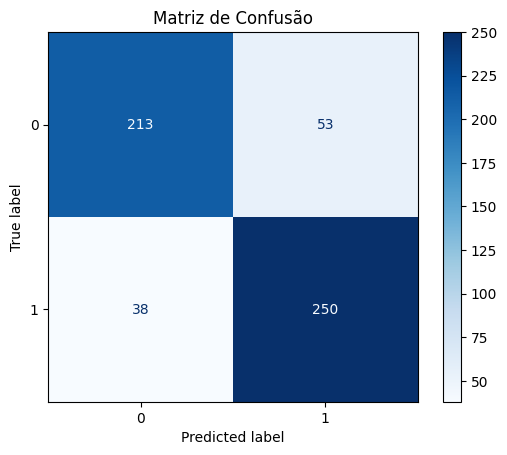

In [ ]:
# Modelo de classificação
#model = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=False)
model = LogisticRegression(C=10, penalty='l2')
model.fit(X_train_tfidf, y_train)

# Previsões
y_pred = model.predict(X_test_tfidf)

# Relatório de classificação
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

Curva ROC e AUC

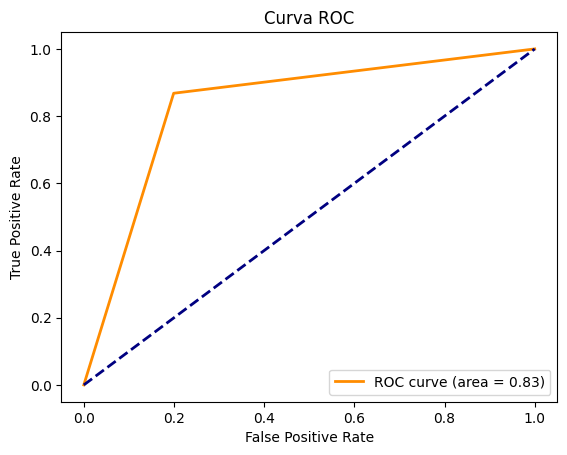

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Saving the model

In [ ]:
import joblib

joblib.dump(model, 'review_classifier_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']